# Bayesian neural network

First, we load the modules we need:

In [16]:
import jax.numpy as jnp
import jax
from jaxtyping import Array, Float
from dataclasses import dataclass

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import distrax as dx

from coinem.model import AbstractModel
from coinem.dataset import Dataset

# Pyplot for plots.
import matplotlib.pyplot as plt 

from jax import vmap

## Model

Decribe.

In [28]:
@dataclass
class BayesNN(AbstractModel):
    """Base class for p(θ, x)."""
    w_shape: tuple[int, int] = (40, 784)
    v_dim: tuple[int, int] = (2, 40)
    
    def log_prob(self, latent: Float[Array, "D"], theta: Float[Array, "Q"], data: Dataset) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (2,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """
        X = data.X # [Batchsize, 28, 28]
        y = data.y # [Batchsize, 1]


        # Unpack theta
        alpha, beta = theta

        # Unpack latent variables:
        w_flat = latent[:self.w_shape[0] * self.w_shape[1]]
        v_flat = latent[self.w_shape[0] * self.w_shape[1]:]

        assert w_flat.shape == (self.w_shape[0] * self.w_shape[1],)
        assert v_flat.shape == (self.v_dim[0] * self.v_dim[1],)

        w = w_flat.reshape(self.w_shape) # [40, 784]
        v = v_flat.reshape(self.v_dim) # [2, 40]


        # Compute prior:
        log_prior_w = dx.Normal(0.0, jnp.exp(2.0 * alpha.squeeze())).log_prob(w_flat.squeeze()).sum()
        log_prior_v = dx.Normal(0.0, jnp.exp(2.0 * beta.squeeze())).log_prob(v_flat.squeeze()).sum()


        def _log_nn(image):
            # Log of the network's output when evaluated at image with weights w, v.
            return jax.nn.log_softmax(jnp.dot(v, jnp.tanh(jnp.dot(w, image.flatten())))) 


        def _log_nn_vec(images):
            # _log_nn vectorized over particles.
            return jax.vmap(_log_nn)(images)


        def _log_likelihood(images, labels):
            
            # Log-likelihood for set of images and labels, vectorized over particles.

            V = _log_nn_vec(images) # [Batchsize, 2]

            return vmap(lambda v, l : v[l])(V, labels).sum()


        # Compute log-probability.
        return  (_log_likelihood(X, y) + log_prior_w + log_prior_v) / data.n # log p(y|x) + log p(x|theta) 

Next, we load and curate the dataset:

In [29]:
#@title Load, subsample, and normalize MNIST dataset.
import numpy as np

# Load dataset:
from keras.datasets import mnist
(images, labels), _ = mnist.load_data()
images = np.array(images).astype(float)
labels = np.array(labels).astype(int)

# Keep only datapoints with labels 4 and 9:
indices = (labels == 4) | (labels == 9)
labels = labels[indices]
images = images[indices, :, :]

# Relabel as 4 as 0 and 9 as 1:
for n in range(labels.size):
    if labels[n] == 4:
        labels[n] = 0
    else:
        labels[n] = 1

# Sub-sample 1000 images:
from sklearn.model_selection import train_test_split
images, _, labels, _ = train_test_split(images, labels, train_size=1000,
                                        random_state=0)

# Normalize non-zero entries so that they have mean zero and unit standard 
# across the dataset:'''
i = images.std(0) != 0
images[:, i] = (images[:, i] - images[:, i].mean(0))/images[:, i].std(0)

# Split data into 80/20 training and testing sets:
itrain, itest, ltrain, ltest = train_test_split(images, labels, test_size=0.2,
                                                random_state=0)

from coinem.dataset import Dataset

data = Dataset(jnp.array(itrain), jnp.array(ltrain).reshape(-1, 1))


We then implement the algorithms. They take in the following inputs:

*   itrain : training set labels,
*   itrain : training set images,
*   itest : test set labels,
*   itest : test set images,
*   h : step-size,
*   K : number of steps,
*   N : number of particles,
*   a : 1-dimensional vector with initial alpha guess,
*   b : 1-dimensional vector with initial beta guess,
*   w : Dw x N matrix storing the input layer weights of the initial particle cloud,
*   v : Dv x N matrix storing the output layer weights of the initial particle cloud.

They return the following outputs:

*   a : K-dimensional vector of alpha estimates,
*   b : K-dimensional vector of beta estimates,
*   w : Dw x N matrix storing the input layer weights of the final particle cloud,
*   v : Dv x N matrix storing the output layer weights of the final particle cloud,
*   lppd : log pointwise predictive density (LPPD) as a function of k,
*   error : test error as a function of k.

We can now run the algorithms using an 80/20 training/test split of the data:

In [35]:


# Set approximation parameters:
h = 1e-1 # Step-size. 
K = 1000  # Number of steps.
N = 100  # Number of particles.

key = jr.PRNGKey(42)

alpha = jnp.array(0.0)
beta = jnp.array(0.0)
theta = jnp.array([alpha, beta])



# Initialize particle cloud by sampling prior:'
w_flat = jnp.exp(alpha) * jr.normal(key, (N, 40 * 28**2))  # Input layer weights.
v_flat = jnp.exp(beta) * jr.normal(key, (N, 2*40))  # Output layer weights.
latent = jnp.concatenate((w_flat, v_flat), axis=1)


from coinem.zoo import coin_svgd, pgd, adam_svgd, soul
model = BayesNN()

x_coin, theta_coin = coin_svgd(model, data, latent, theta, K)
x_pgd, theta_pgd = pgd(model, data, latent, theta, K, latent_step_size=1e-2, theta_step_size=1e-2)
x_adam, theta_adam = adam_svgd(model, data, latent, theta, K, latent_step_size=1e-1, theta_step_size=1e-1)
x_soul, theta_soul = soul(model, data, latent, theta, K, latent_step_size=1e-2, theta_step_size=1e-2)

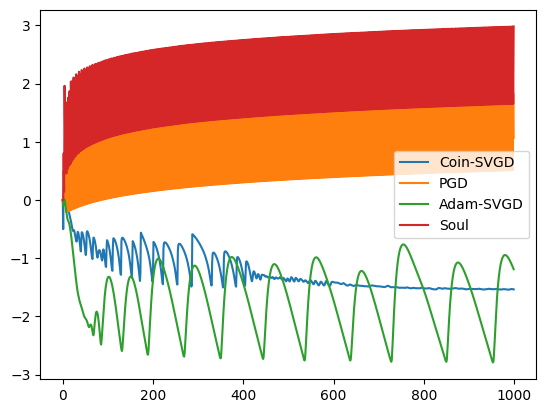

In [36]:
plt.plot(theta_coin[:, 0], label="Coin-SVGD")
plt.plot(theta_pgd[:, 0], label="PGD")
plt.plot(theta_adam[:, 0], label="Adam-SVGD")
plt.plot(theta_soul[:, 0], label="Soul")
plt.legend()

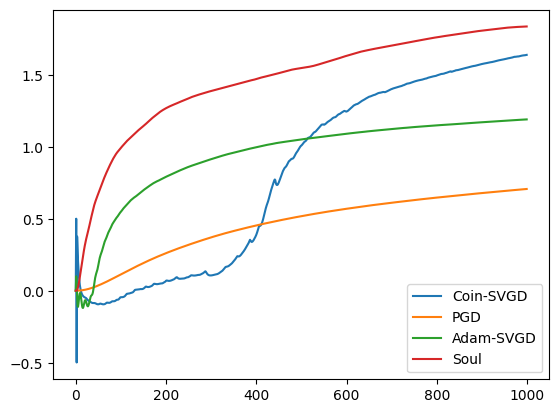

In [37]:
plt.plot(theta_coin[:, 1], label="Coin-SVGD")
plt.plot(theta_pgd[:, 1], label="PGD")
plt.plot(theta_adam[:, 1], label="Adam-SVGD")
plt.plot(theta_soul[:, 1], label="Soul")
plt.legend()

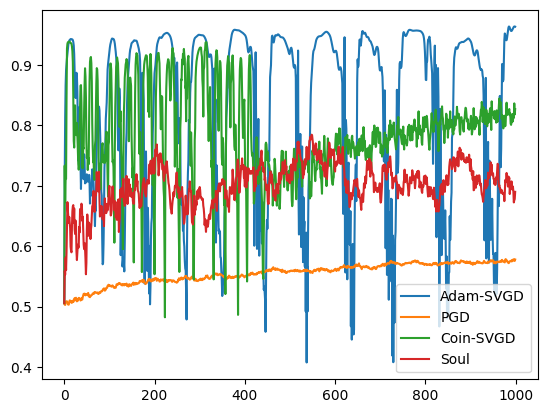

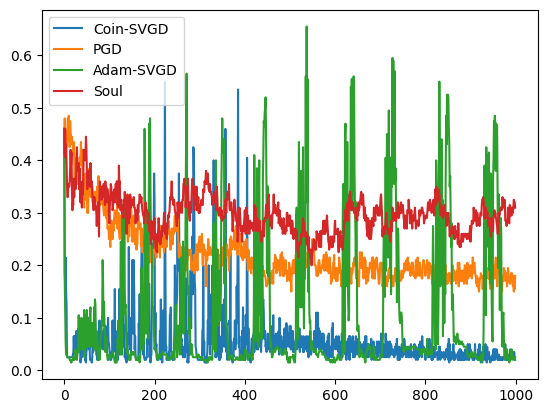

In [38]:
def log_pointwise_predrictive_density(model, latent_particles, images, labels):
    """Returns LPPD for set of (test) images and labels."""

    def _latent_cal(latent):

        # Unpack latent variables:
        w_flat = latent[:model.w_shape[0] * model.w_shape[1]]
        v_flat = latent[model.w_shape[0] * model.w_shape[1]:]

        assert w_flat.shape == (model.w_shape[0] * model.w_shape[1],)
        assert v_flat.shape == (model.v_dim[0] * model.v_dim[1],)

        w = w_flat.reshape(model.w_shape) # [40, 784]
        v = v_flat.reshape(model.v_dim) # [2, 40]


        def _log_nn(image):
                # Log of the network's output when evaluated at image with weights w, v.
                return jax.nn.softmax(jnp.dot(v, jnp.tanh(jnp.dot(w, image.flatten())))) 


        def _log_nn_vec(images):
            # _log_nn vectorized over particles.
            return jax.vmap(_log_nn)(images)


        return _log_nn_vec(images)
    
    s = jax.vmap(_latent_cal)(latent_particles).mean(0)
    return vmap(lambda v, l : v[l])(s, labels).mean()




def _predict(model, latent_particles, images):
    """Returns LPPD for set of (test) images and labels."""

    def _latent_cal(latent):

        # Unpack latent variables:
        w_flat = latent[:model.w_shape[0] * model.w_shape[1]]
        v_flat = latent[model.w_shape[0] * model.w_shape[1]:]

        assert w_flat.shape == (model.w_shape[0] * model.w_shape[1],)
        assert v_flat.shape == (model.v_dim[0] * model.v_dim[1],)

        w = w_flat.reshape(model.w_shape) # [40, 784]
        v = v_flat.reshape(model.v_dim) # [2, 40]


        def _log_nn(image):
                # Log of the network's output when evaluated at image with weights w, v.
                return jax.nn.softmax(jnp.dot(v, jnp.tanh(jnp.dot(w, image.flatten())))) 


        def _log_nn_vec(images):
            # _log_nn vectorized over particles.
            return jax.vmap(_log_nn)(images)


        return _log_nn_vec(images)
    
    s = jax.vmap(_latent_cal)(latent_particles).mean(0)
    return jnp.argmax(s, axis=1)


def test_error(model, latent_particles, images, labels):
    """Returns fraction of misclassified images in test set."""
    return jnp.abs(labels.squeeze() - _predict(model, latent_particles, images)).mean()

plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_adam), label="Adam-SVGD")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_pgd), label="PGD")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_coin), label="Coin-SVGD")
plt.plot(vmap(lambda p: log_pointwise_predrictive_density(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_soul), label="Soul")
plt.legend()
plt.show()

plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_coin), label="Coin-SVGD")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_pgd), label="PGD")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_adam), label="Adam-SVGD")
plt.plot(vmap(lambda p: test_error(model, p, jnp.array(itest), jnp.array(ltest).reshape(-1, 1)))(x_soul), label="Soul")
plt.legend()
plt.show()